In [733]:
import numpy as np
import matplotlib.pyplot as plt
import datetime
from scipy.interpolate import interp1d
import pandas as pd
import matplotlib.patches as patches

# imports the permutation function to generate all permutations of 2 of the FANG stocks
from itertools import permutations
# imports test for Granger Causality (does variable x have value in predicting y)
from statsmodels.tsa.stattools import grangercausalitytests

from statsmodels.tsa.vector_ar.vecm import *
from statsmodels.tsa.api import VAR

In [734]:
plt.style.use('/home/luuk/Documents/MNRAS_stylesheet')

In [ ]:
GDP_growth = pd.read_csv('./VARmodel/quarterly_gdp_growth_y2y.csv').set_index(['Subject','Measure','Country','TIME']).loc['Gross domestic product - expenditure approach'].loc['Growth rate compared to the same quarter of previous year, seasonally adjusted'].loc['Netherlands']#[['Value']]
GDP_growth = GDP_growth[['Value']]
GDP_growth.columns=['GDPGrowth']
GDP_growth.index = pd.to_datetime(GDP_growth.index)

In [952]:
gov_spending = pd.read_csv('./VARmodel/govspending.csv')
gov_spending = gov_spending.set_index('LOCATION').loc['NLD'].set_index('TIME')[['Value']].astype(float)
gov_spending.index = pd.to_datetime(gov_spending.index,format='%Y')
gov_spending.columns = ['GovSpending'] 

In [736]:
quarterly_debt = pd.read_excel('./VARmodel/quarterlydebt.xlsx')
quarterly_debt = quarterly_debt.set_index(['Country Name','Indicator Name']).loc['Netherlands'].loc['Gross PSD, Budgetary Central Gov., All maturities, All instruments, Nominal Value, % of GDP'].dropna()
quarterly_debt = pd.DataFrame(quarterly_debt).iloc[2:]
quarterly_debt.columns = ['Debt']
quarterly_debt.index = pd.to_datetime(quarterly_debt.index)

In [737]:
deficit = pd.read_csv('./VARmodel/deficit',header=None)
deficit.columns = ['Year','col1','deficit']
deficit = deficit.set_index('Year').sort_index()
deficit = deficit[['deficit']]


In [738]:
inflation = pd.read_csv('./VARmodel/inflation_y2y.csv').set_index(['Country','Subject','TIME']).loc['Netherlands'].loc['CPI: 01-12 - All items']
inflation = inflation[['Value']].iloc[:-1]
inflation.columns = ['Inflation']
inflation.index = pd.to_datetime(inflation.index)

In [739]:
interest_rate = pd.read_csv('./VARmodel/interest_rate.csv').set_index(['Country','TIME'])[['Value']].loc['Netherlands']
interest_rate = interest_rate.iloc[:-1]
interest_rate.columns = ['InterestRate']
interest_rate.index = pd.to_datetime(interest_rate.index)

In [740]:
debt = pd.DataFrame(pd.read_excel('./VARmodel/debtNL.xls').iloc[0,1:])
debt.columns = ['debt']
debt = debt.loc[1980:]

<h3>VAR model debt</h3>

In [955]:
GDP_growth_annual = GDP_growth.resample('1Y').mean()
GDP_growth_annual.index = [int(w.strftime('%Y')) for w in GDP_growth_annual.index]
inflation_annual  = inflation.resample('1Y').mean()
inflation_annual.index = [int(w.strftime('%Y')) for w in inflation_annual.index]

In [958]:
df = deficit.join(debt).join(GDP_growth_annual).join(inflation_annual)
df.loc[2019,'debt'] = 48.1
df.index = pd.to_datetime(df.index,format='%Y')
#df = pd.concat((df.iloc[:15],df.iloc[16:]))
df = df.iloc[15:]
df = df.astype(float)
#df = df.join(gov_spending)
df

,deficit,debt,GDPGrowth,Inflation
Year,,,,
1995-01-01,-8.7,72.212158,3.255405,1.925973
1996-01-01,-1.8,70.482989,3.286608,2.113292
1997-01-01,-1.6,64.852349,4.504322,2.108353
1998-01-01,-1.4,61.663222,4.566250,1.960187
1999-01-01,0.3,57.531964,4.921405,2.157332
2000-01-01,1.2,50.901867,4.285616,2.358545
2001-01-01,-0.5,48.159815,2.341519,4.155658
2002-01-01,-2.1,47.534507,0.218380,3.290661
2003-01-01,-3.1,48.716094,0.213047,2.093244


In [959]:
model = VAR(df)#, dates=df.index)
results = model.fit(3,trend='nc')
results.summary()

/home/luuk/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  warnings.warn('No frequency information was'


  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Wed, 20, Jan, 2021
Time:                     23:14:14
--------------------------------------------------------------------
No. of Equations:         4.00000    BIC:                    4.98955
Nobs:                     22.0000    HQIC:                   3.16986
Log likelihood:          -105.567    FPE:                    23.1169
AIC:                      2.60910    Det(Omega_mle):         4.05232
--------------------------------------------------------------------
Results for equation deficit
                  coefficient       std. error           t-stat            prob
-------------------------------------------------------------------------------
L1.deficit           0.845605         0.246687            3.428           0.001
L1.debt             -0.304068         0.069728           -4.361           0.000
L1.GDPGrowth        -0.484104         0.227003           -2.13

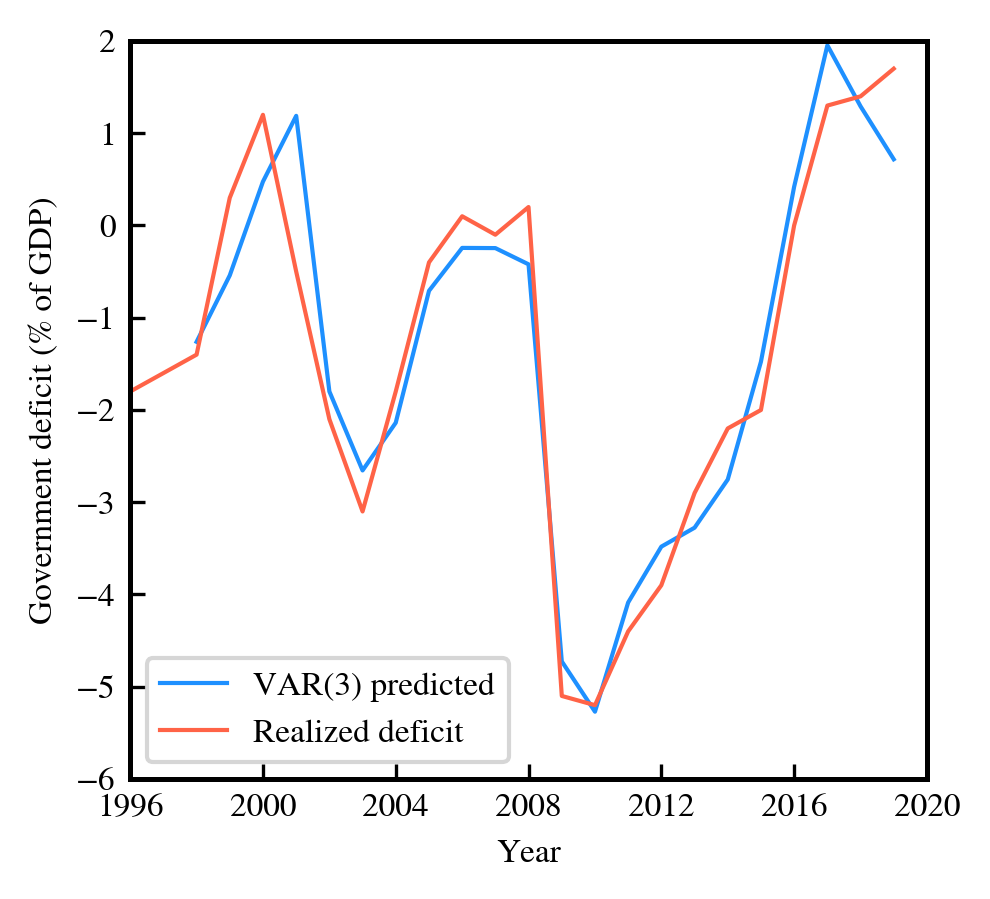

In [960]:
fig,ax = plt.subplots()

ax.plot(results.fittedvalues.deficit.index,results.fittedvalues.deficit.values,label='VAR(3) predicted',color='dodgerblue',lw=1)
ax.plot(df.deficit.index, df.deficit,label='Realized deficit',color='tomato',lw=1)
plt.legend(frameon=True)
plt.xlabel('Year')
plt.ylabel('Government deficit (% of GDP)')
plt.tight_layout()
plt.ylim(-6,2)
plt.xlim(datetime.date(1996,1,1),datetime.date(2020,1,1))
plt.savefig('Gov_deficit_VAR3.pdf',bbox_inches='tight')

<h3>VAR model quarterly</h3>

In [757]:
df = GDP_growth.join(inflation).join(interest_rate).join(quarterly_debt)
df.index = pd.to_datetime(df.index)
#df = df.iloc[76:-4]
df = df.dropna()
df = df.astype(float)
df

,GDPGrowth,Inflation,InterestRate,Debt
TIME,,,,
1995-10-01,2.995966,1.530312,6.343333,59.229488
1996-04-01,3.057057,2.154891,6.390000,53.875081
1996-07-01,3.685280,2.045390,6.250000,50.588502
1996-10-01,3.683802,2.313876,5.786667,51.576568
1997-01-01,4.386118,1.909959,5.593333,46.505253
...,...,...,...,...
2015-07-01,2.160347,0.733358,0.901667,53.513722
2015-10-01,1.269539,0.620514,0.731667,51.795790
2016-01-01,1.592632,0.583297,0.445667,49.759518


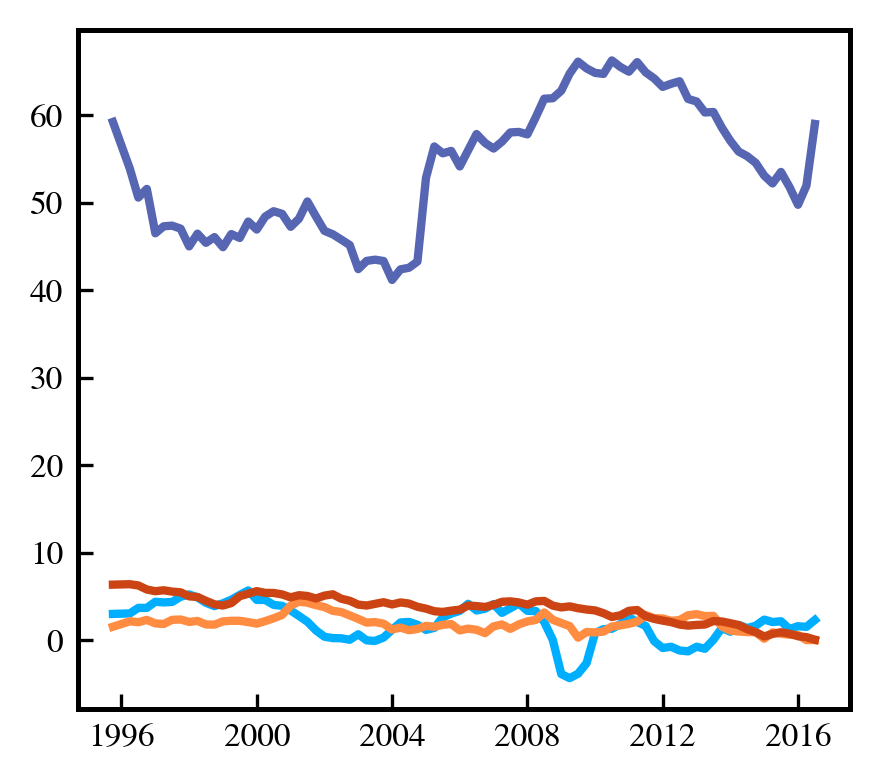

In [746]:
plt.plot(df.index, df.GDPGrowth)
plt.plot(df.index, df.Inflation)
plt.plot(df.index, df.InterestRate)
plt.plot(df.index, df.Debt)

In [855]:
model = VAR(df)#, dates=df.index)
var_results = model.fit(3,trend='nc')
var_results.summary()

/home/luuk/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Wed, 20, Jan, 2021
Time:                     22:00:11
--------------------------------------------------------------------
No. of Equations:         4.00000    BIC:                   -1.70254
Nobs:                     80.0000    HQIC:                  -2.55874
Log likelihood:          -280.790    FPE:                  0.0440413
AIC:                     -3.13175    Det(Omega_mle):       0.0251807
--------------------------------------------------------------------
Results for equation GDPGrowth
                     coefficient       std. error           t-stat            prob
----------------------------------------------------------------------------------
L1.GDPGrowth            1.187218         0.121781            9.749           0.000
L1.Inflation           -0.165250         0.213119           -0.775           0.438
L1.InterestRate         0.710121         0.33889

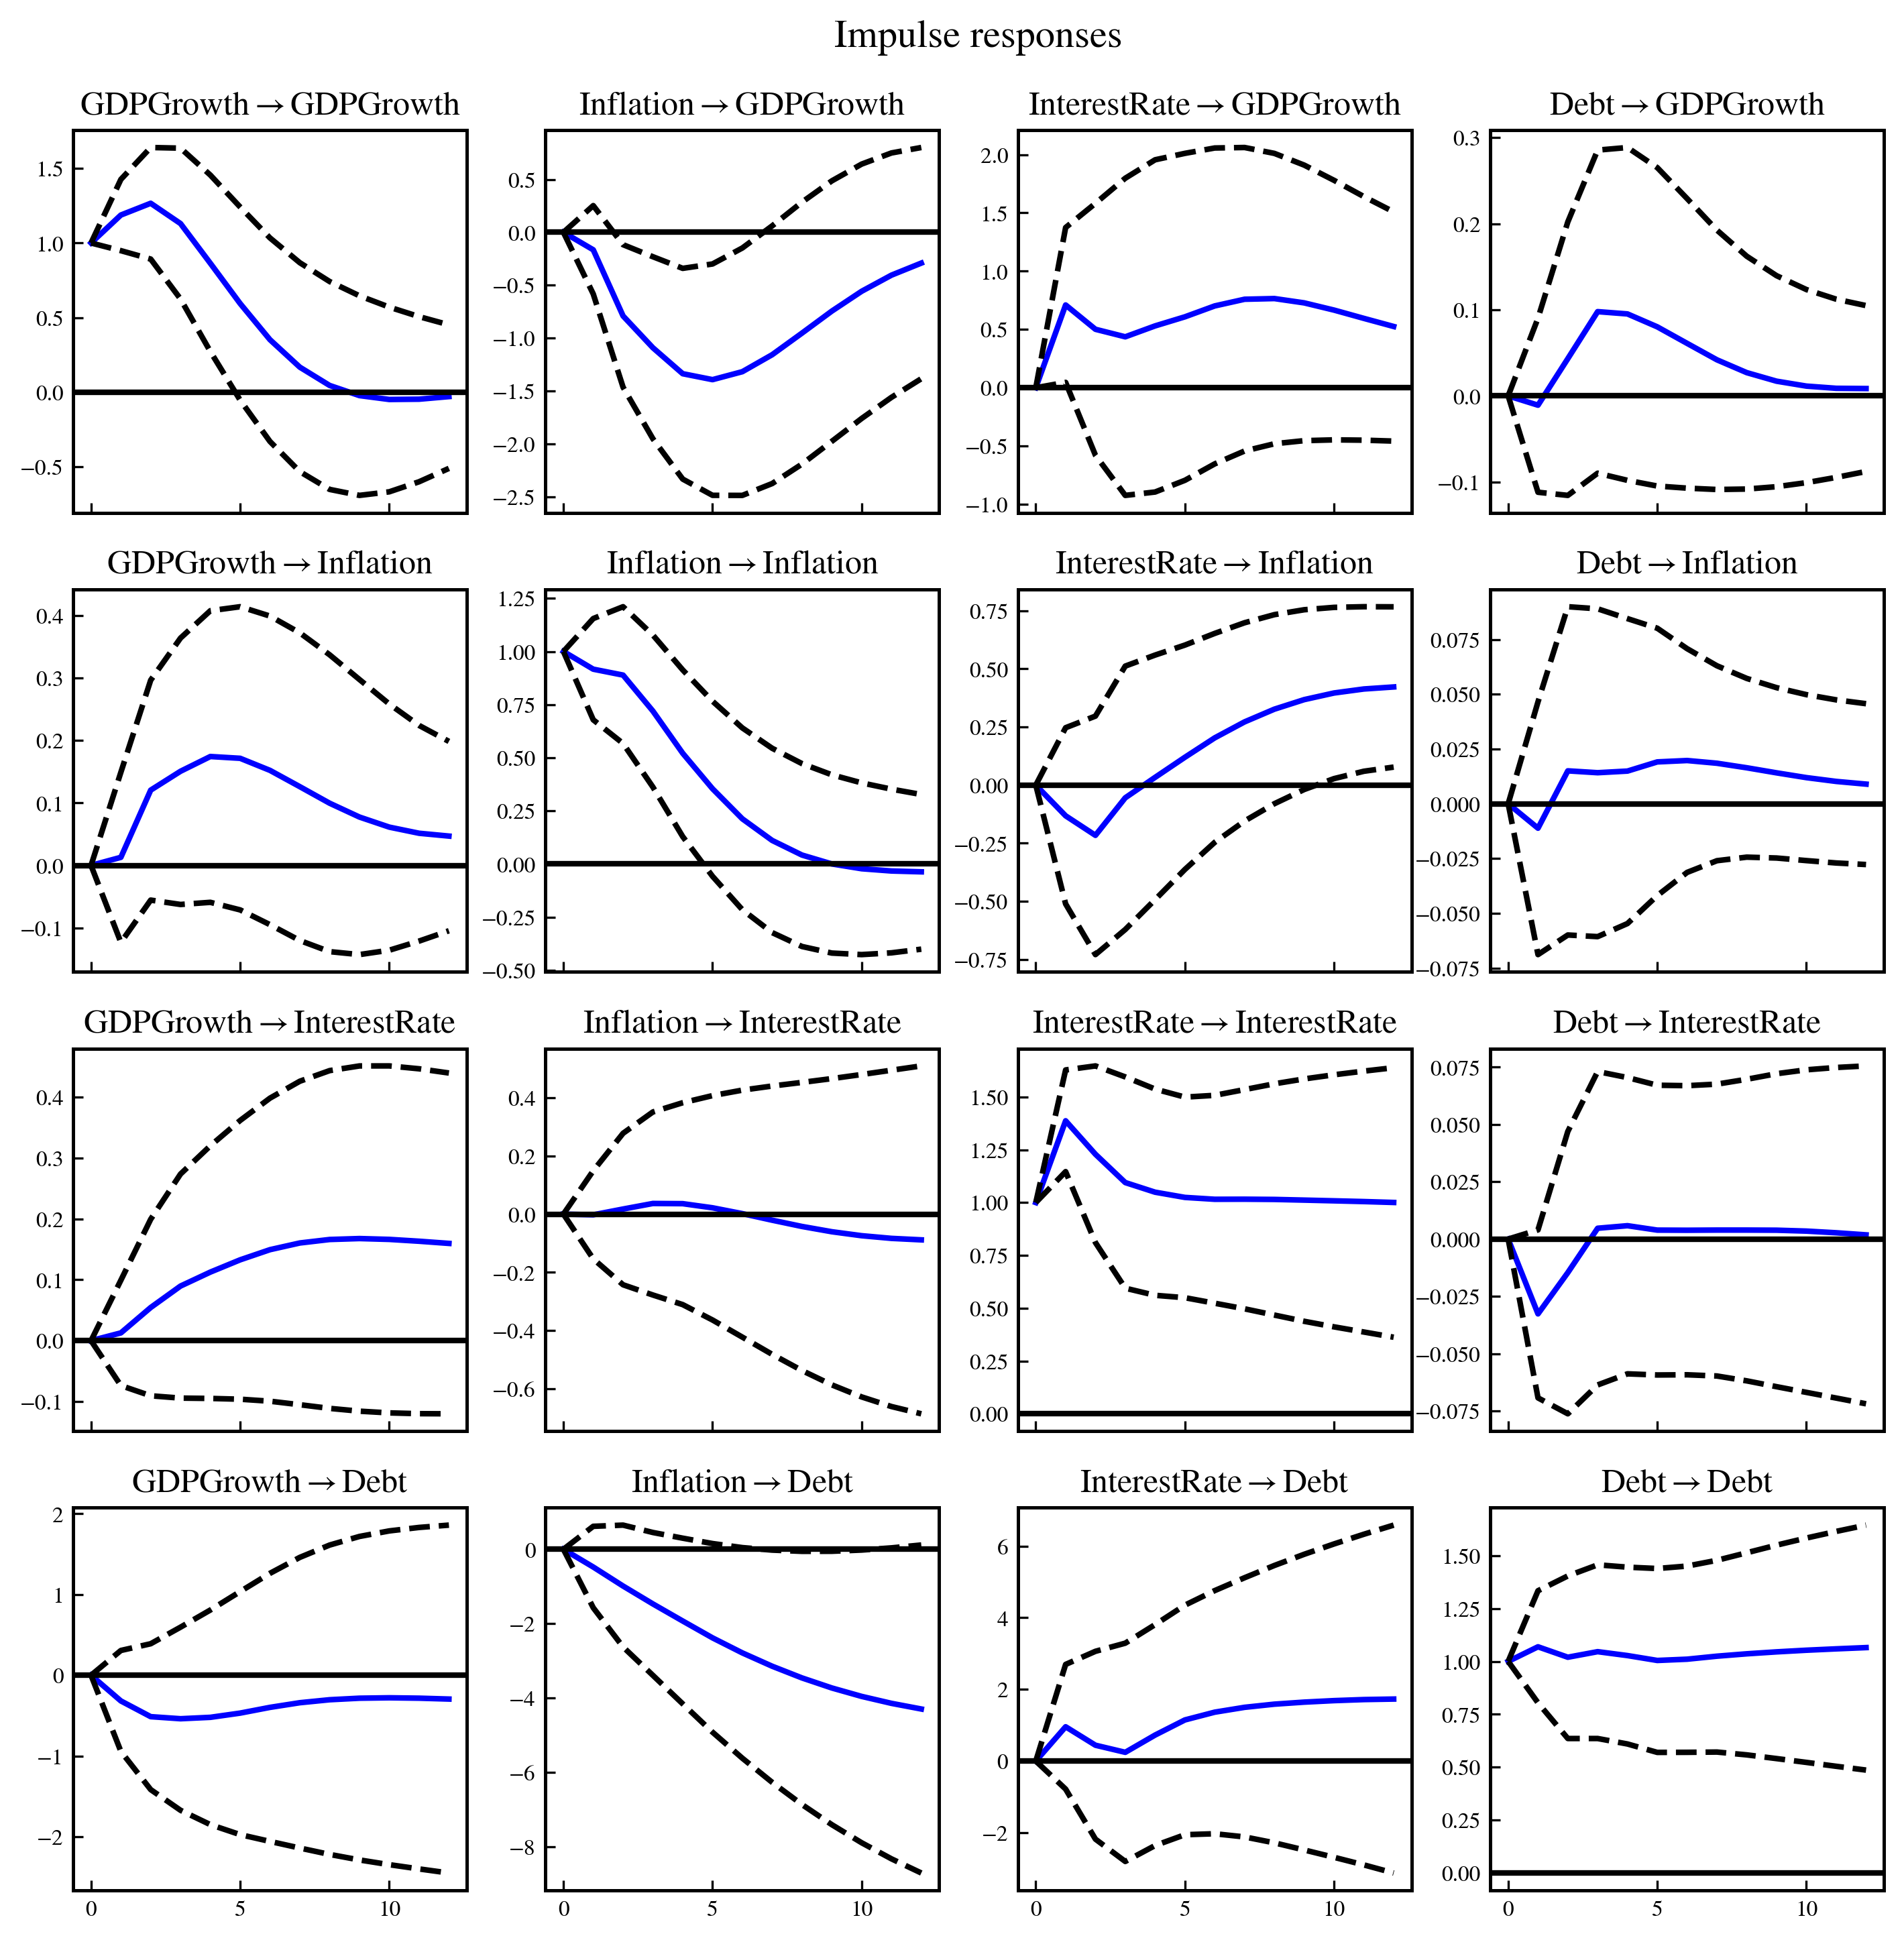

In [866]:
num_periods = 12
ir = var_results.irf(periods=num_periods)
ir.plot(plot_stderr=True)
plt.savefig('VAR_IRF.pdf')

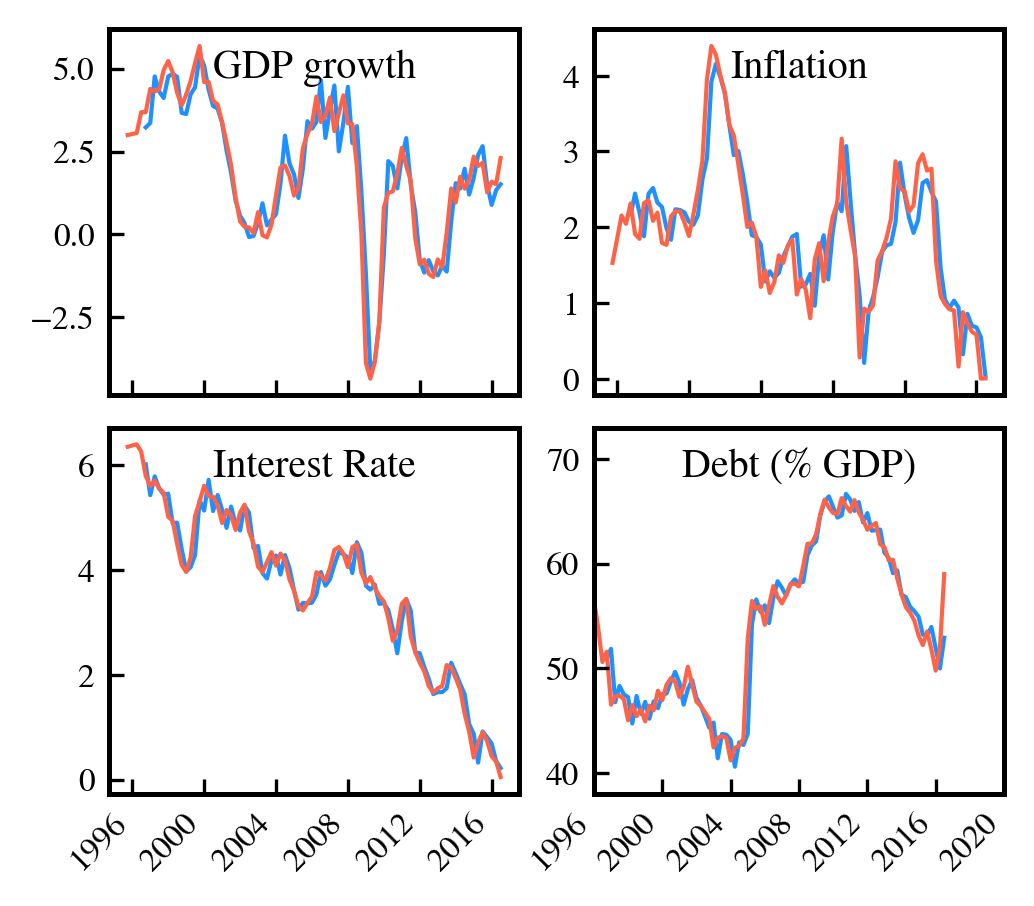

In [797]:
fig,[[ax1,ax2],[ax3,ax4]] = plt.subplots(2,2)

ax1.plot(results.fittedvalues.GDPGrowth.index,results.fittedvalues.GDPGrowth.values,label='VAR prediction',color='dodgerblue',lw=1)
ax1.plot(df.GDPGrowth.index, df.GDPGrowth,label='Realized',color='tomato',lw=1)
ax1.set_xticklabels(len(ax1.get_xticks())*[''])
ax1.set_title('GDP growth',y=0.8)

ax2.plot(results.fittedvalues.Inflation.index,results.fittedvalues.Inflation.values,label='VAR prediction',color='dodgerblue',lw=1)
ax2.plot(df.Inflation.index, df.Inflation,label='Realized',color='tomato',lw=1)
ax2.set_xticklabels(len(ax2.get_xticks())*[''])
ax2.set_title('Inflation',y=0.8)

ax3.plot(results.fittedvalues.InterestRate.index,results.fittedvalues.InterestRate.values,label='VAR prediction',color='dodgerblue',lw=1)
ax3.plot(df.InterestRate.index, df.InterestRate,label='Realized',color='tomato',lw=1)
#ax3.set_xticklabels(len(ax3.get_xticks())*[''])
ax3.set_title('Interest Rate',y=0.8)
fig.autofmt_xdate()

ax4.plot(results.fittedvalues.Debt.index,results.fittedvalues.Debt.values,label='VAR prediction',color='dodgerblue',lw=1)
ax4.plot(df.Debt.index, df.Debt,label='Realized',color='tomato',lw=1)
ax4.set_title('Debt (% GDP)',y=0.8)
ax4.set_ylim(38,73)
fig.autofmt_xdate(rotation=45)

#plt.legend(frameon=True)
#plt.xlabel('Year')
#plt.ylabel('Government deficit (% of GDP)')
plt.tight_layout(pad=0.8)
#plt.ylim(-6,2)
plt.xlim(datetime.date(1996,1,1),datetime.date(2020,1,1))
plt.savefig('2x2VARpredictions.pdf',bbox_inches='tight')

<h3>VECM</h3>

In [838]:
from statsmodels.tsa.vector_ar.vecm import *

In [840]:
lag_order = select_order(data=df, maxlags=7, deterministic="nc", seasons=0)
lag_order.summary()


/home/luuk/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/home/luuk/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/home/luuk/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/home/luuk/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:216: ValueWarning: A date index has been pro

,AIC,BIC,FPE,HQIC
0,-3.213,-2.595*,0.04027,-2.966*
1,-3.320*,-2.207,0.03634*,-2.875
2,-3.157,-1.550,0.04315,-2.516
3,-3.028,-0.9268,0.04999,-2.189
4,-2.940,-0.3444,0.05622,-1.904
5,-2.742,0.3482,0.07166,-1.508
6,-2.980,0.6045,0.06019,-1.549
7,-2.865,1.214,0.07373,-1.237


In [841]:
lag_order.aic, lag_order.bic, lag_order.fpe, lag_order.hqic


(1, 0, 1, 0)

In [934]:
rank_test = select_coint_rank(df, 0, 1, method="trace",
                              signif=0.05)
rank_test.summary()


r_0,r_1,test statistic,critical value
0,4,52.81,47.85
1,4,17.63,29.80


In [929]:
model = VECM(df, deterministic="nc", seasons=0,
             k_ar_diff=4,#lag_order.aic,  
             coint_rank=rank_test.rank)
vecm_res = model.fit()
vecm_res.summary()

/home/luuk/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


,coef,std err,z,P>|z|,[0.025,0.975]
L1.GDPGrowth,0.2978,0.108,2.758,0.006,0.086,0.509
L1.Inflation,-0.1182,0.195,-0.606,0.544,-0.500,0.264
L1.InterestRate,0.8754,0.298,2.941,0.003,0.292,1.459
L1.Debt,0.0234,0.046,0.506,0.613,-0.067,0.114
L2.GDPGrowth,0.0435,0.110,0.395,0.693,-0.172,0.259
L2.Inflation,-0.5601,0.194,-2.889,0.004,-0.940,-0.180
L2.InterestRate,-1.0283,0.316,-3.258,0.001,-1.647,-0.410
L2.Debt,0.1263,0.048,2.643,0.008,0.033,0.220
L3.GDPGrowth,0.0692,0.102,0.678,0.498,-0.131,0.269
L3.Inflation,-0.1139,0.203,-0.560,0.575,-0.512,0.285


In [932]:
for table in vecm_res.summary().tables[:4]:
    print(table.as_latex_tabular(),5*'\n')

\begin{center}
\begin{tabular}{lcccccc}
\toprule
                         & \textbf{coef} & \textbf{std err} & \textbf{z} & \textbf{P$> |$z$|$} & \textbf{[0.025} & \textbf{0.975]}  \\
\midrule
\textbf{L1.GDPGrowth}    &       0.2978  &        0.108     &     2.758  &         0.006        &        0.086    &        0.509     \\
\textbf{L1.Inflation}    &      -0.1182  &        0.195     &    -0.606  &         0.544        &       -0.500    &        0.264     \\
\textbf{L1.InterestRate} &       0.8754  &        0.298     &     2.941  &         0.003        &        0.292    &        1.459     \\
\textbf{L1.Debt}         &       0.0234  &        0.046     &     0.506  &         0.613        &       -0.067    &        0.114     \\
\textbf{L2.GDPGrowth}    &       0.0435  &        0.110     &     0.395  &         0.693        &       -0.172    &        0.259     \\
\textbf{L2.Inflation}    &      -0.5601  &        0.194     &    -2.889  &         0.004        &       -0.940    &       -0.18

In [931]:
for table in vecm_res.summary().tables[:5]:
    table = pd.DataFrame(table)
    table.columns = table.iloc[0,:]
    table = table.iloc[1:,:]
    table.columns = ['parameter','Coefficient','std err','z','P>|z|','[0.025','0.975]']
    table = table.set_index('parameter')
    for col in table.columns:
        table[col]= table[col].apply(lambda x: float(x.data))
    table = table[table['P>|z|']<0.1]
    print(table.to_latex(bold_rows=True,c))

\begin{tabular}{lrrrrrr}
\toprule
{} &  Coefficient &  std err &      z &  P>|z| &  [0.025 &  0.975] \\
\textbf{parameter      } &              &          &        &        &         &         \\
\midrule
\textbf{L1.GDPGrowth   } &       0.2978 &    0.108 &  2.758 &  0.006 &   0.086 &   0.509 \\
\textbf{L1.InterestRate} &       0.8754 &    0.298 &  2.941 &  0.003 &   0.292 &   1.459 \\
\textbf{L2.Inflation   } &      -0.5601 &    0.194 & -2.889 &  0.004 &  -0.940 &  -0.180 \\
\textbf{L2.InterestRate} &      -1.0283 &    0.316 & -3.258 &  0.001 &  -1.647 &  -0.410 \\
\textbf{L2.Debt        } &       0.1263 &    0.048 &  2.643 &  0.008 &   0.033 &   0.220 \\
\textbf{L3.Debt        } &      -0.0810 &    0.048 & -1.691 &  0.091 &  -0.175 &   0.013 \\
\textbf{L4.GDPGrowth   } &      -0.2632 &    0.099 & -2.656 &  0.008 &  -0.457 &  -0.069 \\
\textbf{L4.Inflation   } &      -0.4628 &    0.192 & -2.411 &  0.016 &  -0.839 &  -0.087 \\
\bottomrule
\end{tabular}

\begin{tabular}{lrrrrrr}
\toprul

In [922]:
table

,Coefficient,std err,z,P>|z|,[0.025,0.975]
parameter,,,,,,
beta.1,1.0000,0.000,0.000,0.000,1.000,1.000
beta.2,-33.2760,8.276,-4.021,0.000,-49.497,-17.055
beta.3,13.2557,3.919,3.383,0.001,5.575,20.936


In [912]:
float(a.data)

-0.084

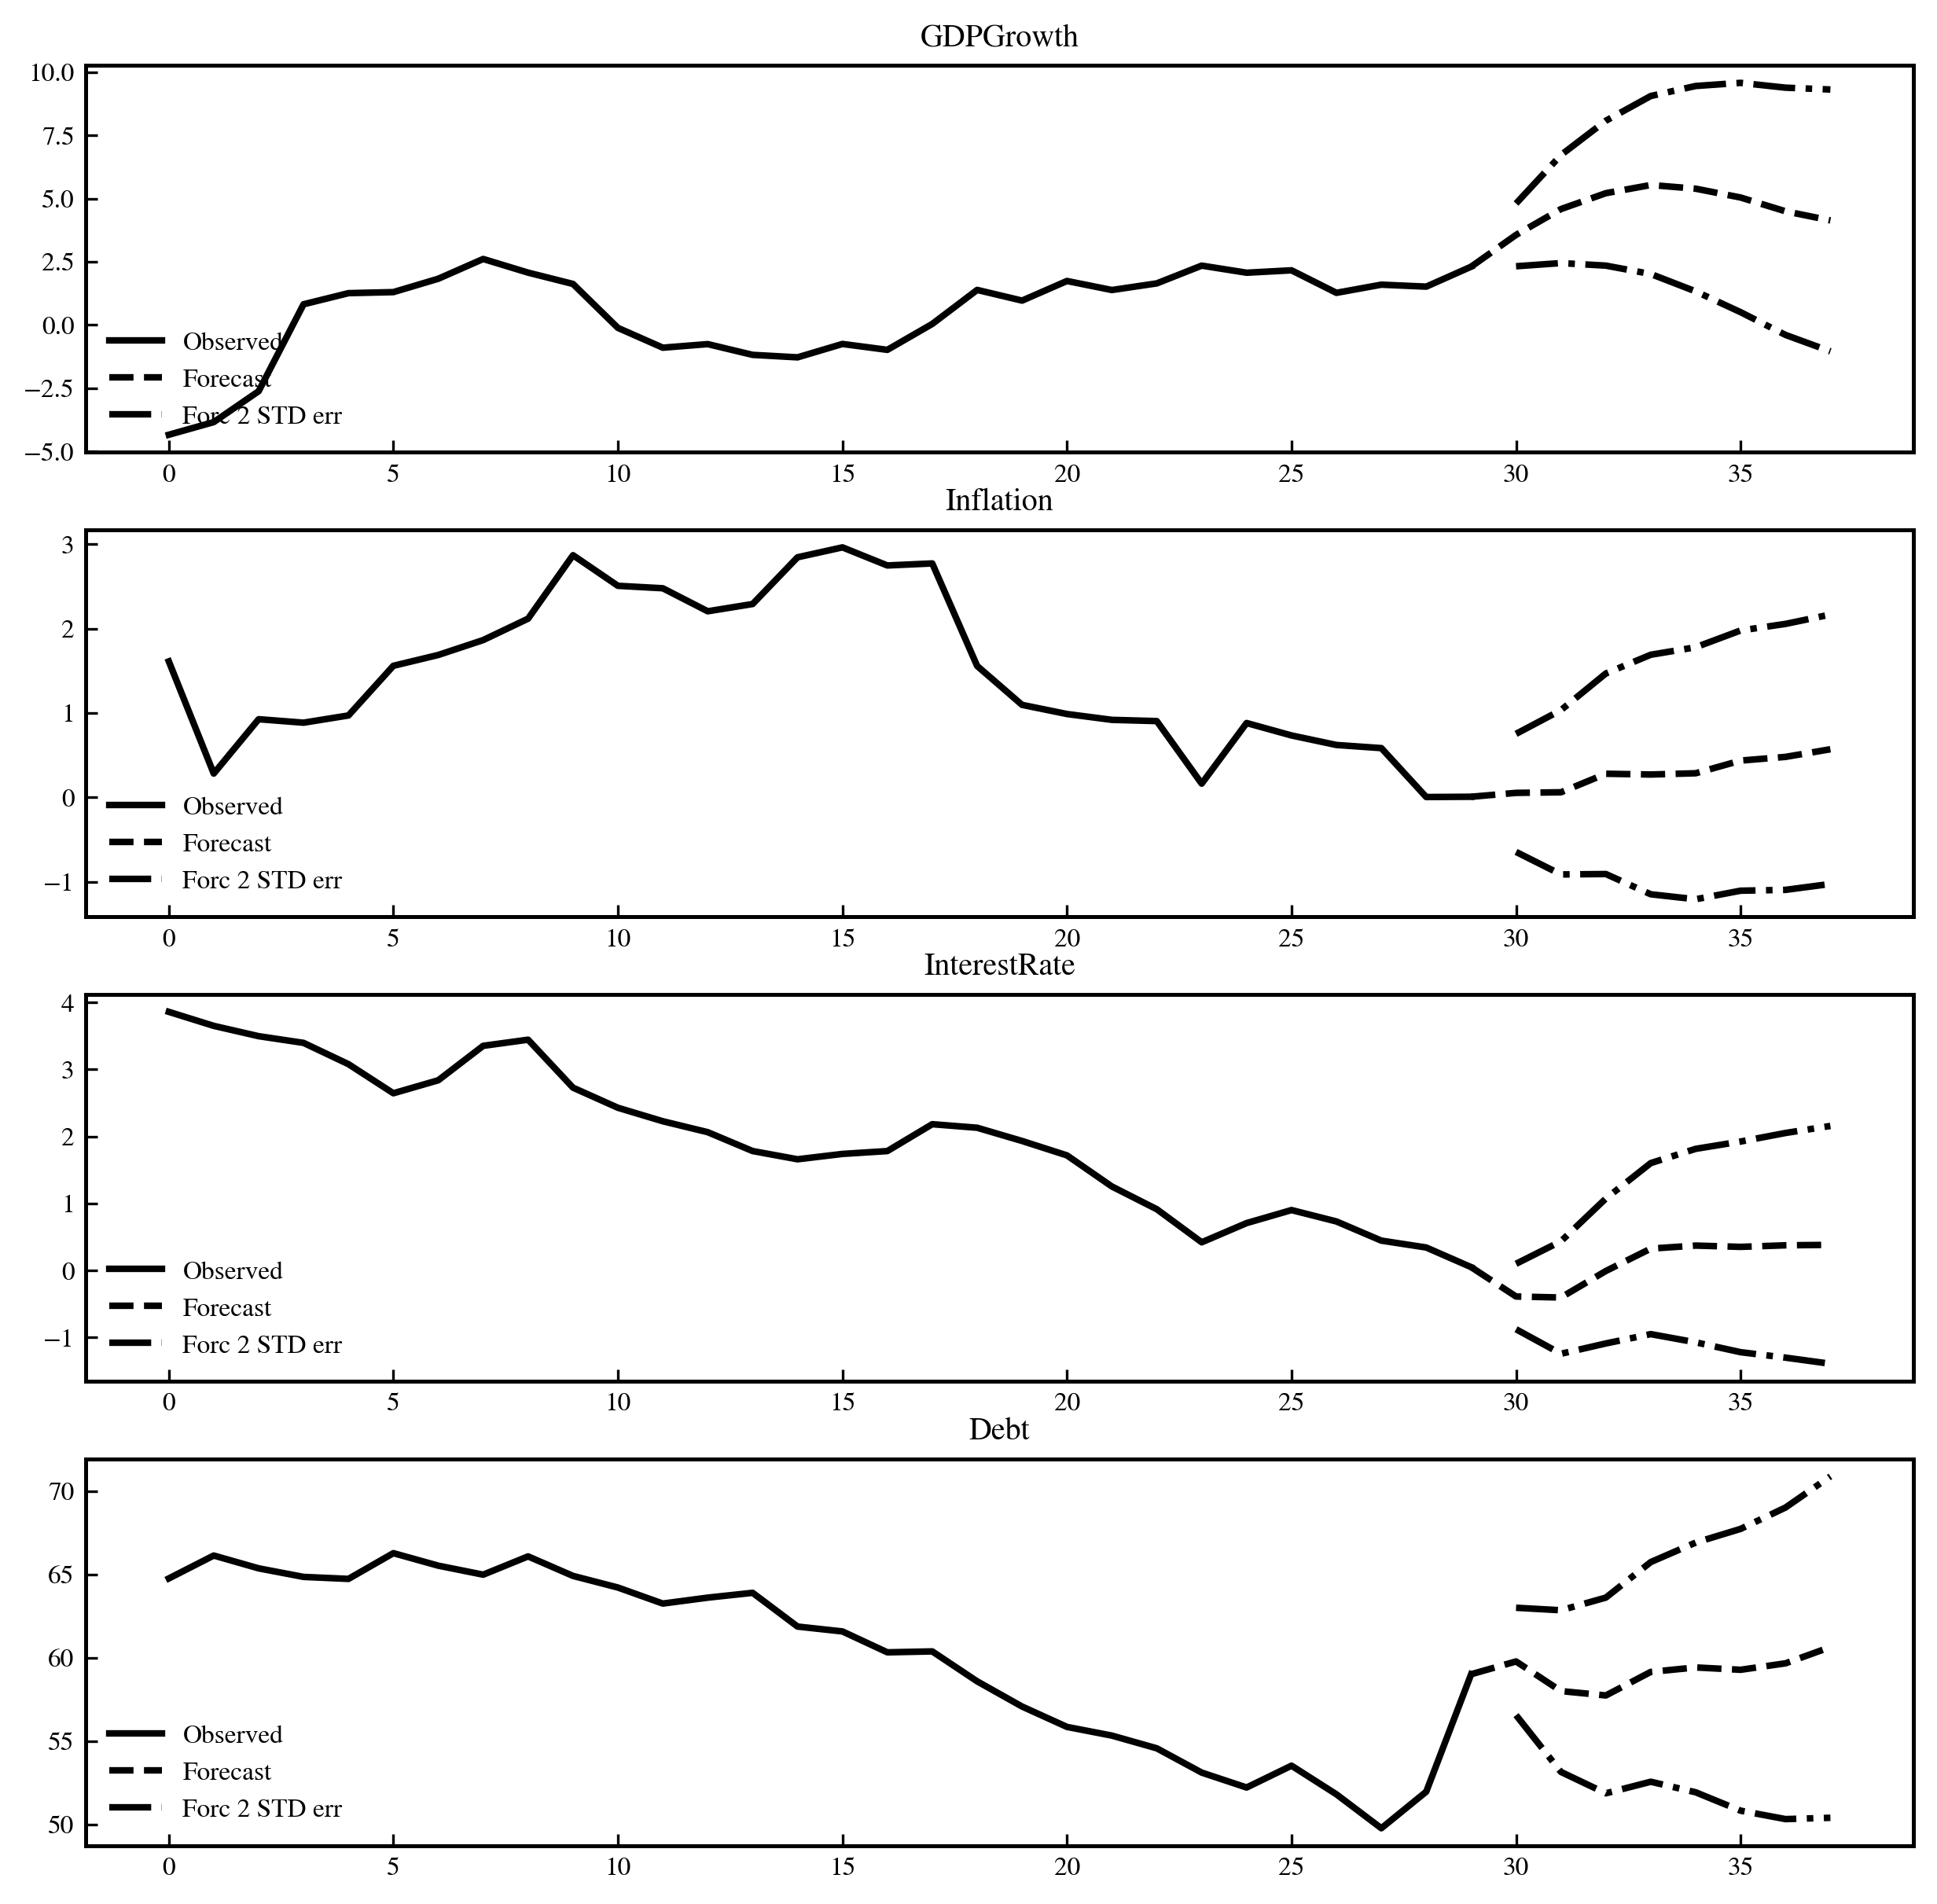

In [851]:
vecm_res.plot_forecast(steps=8, plot_conf_int=True,n_last_obs=30)

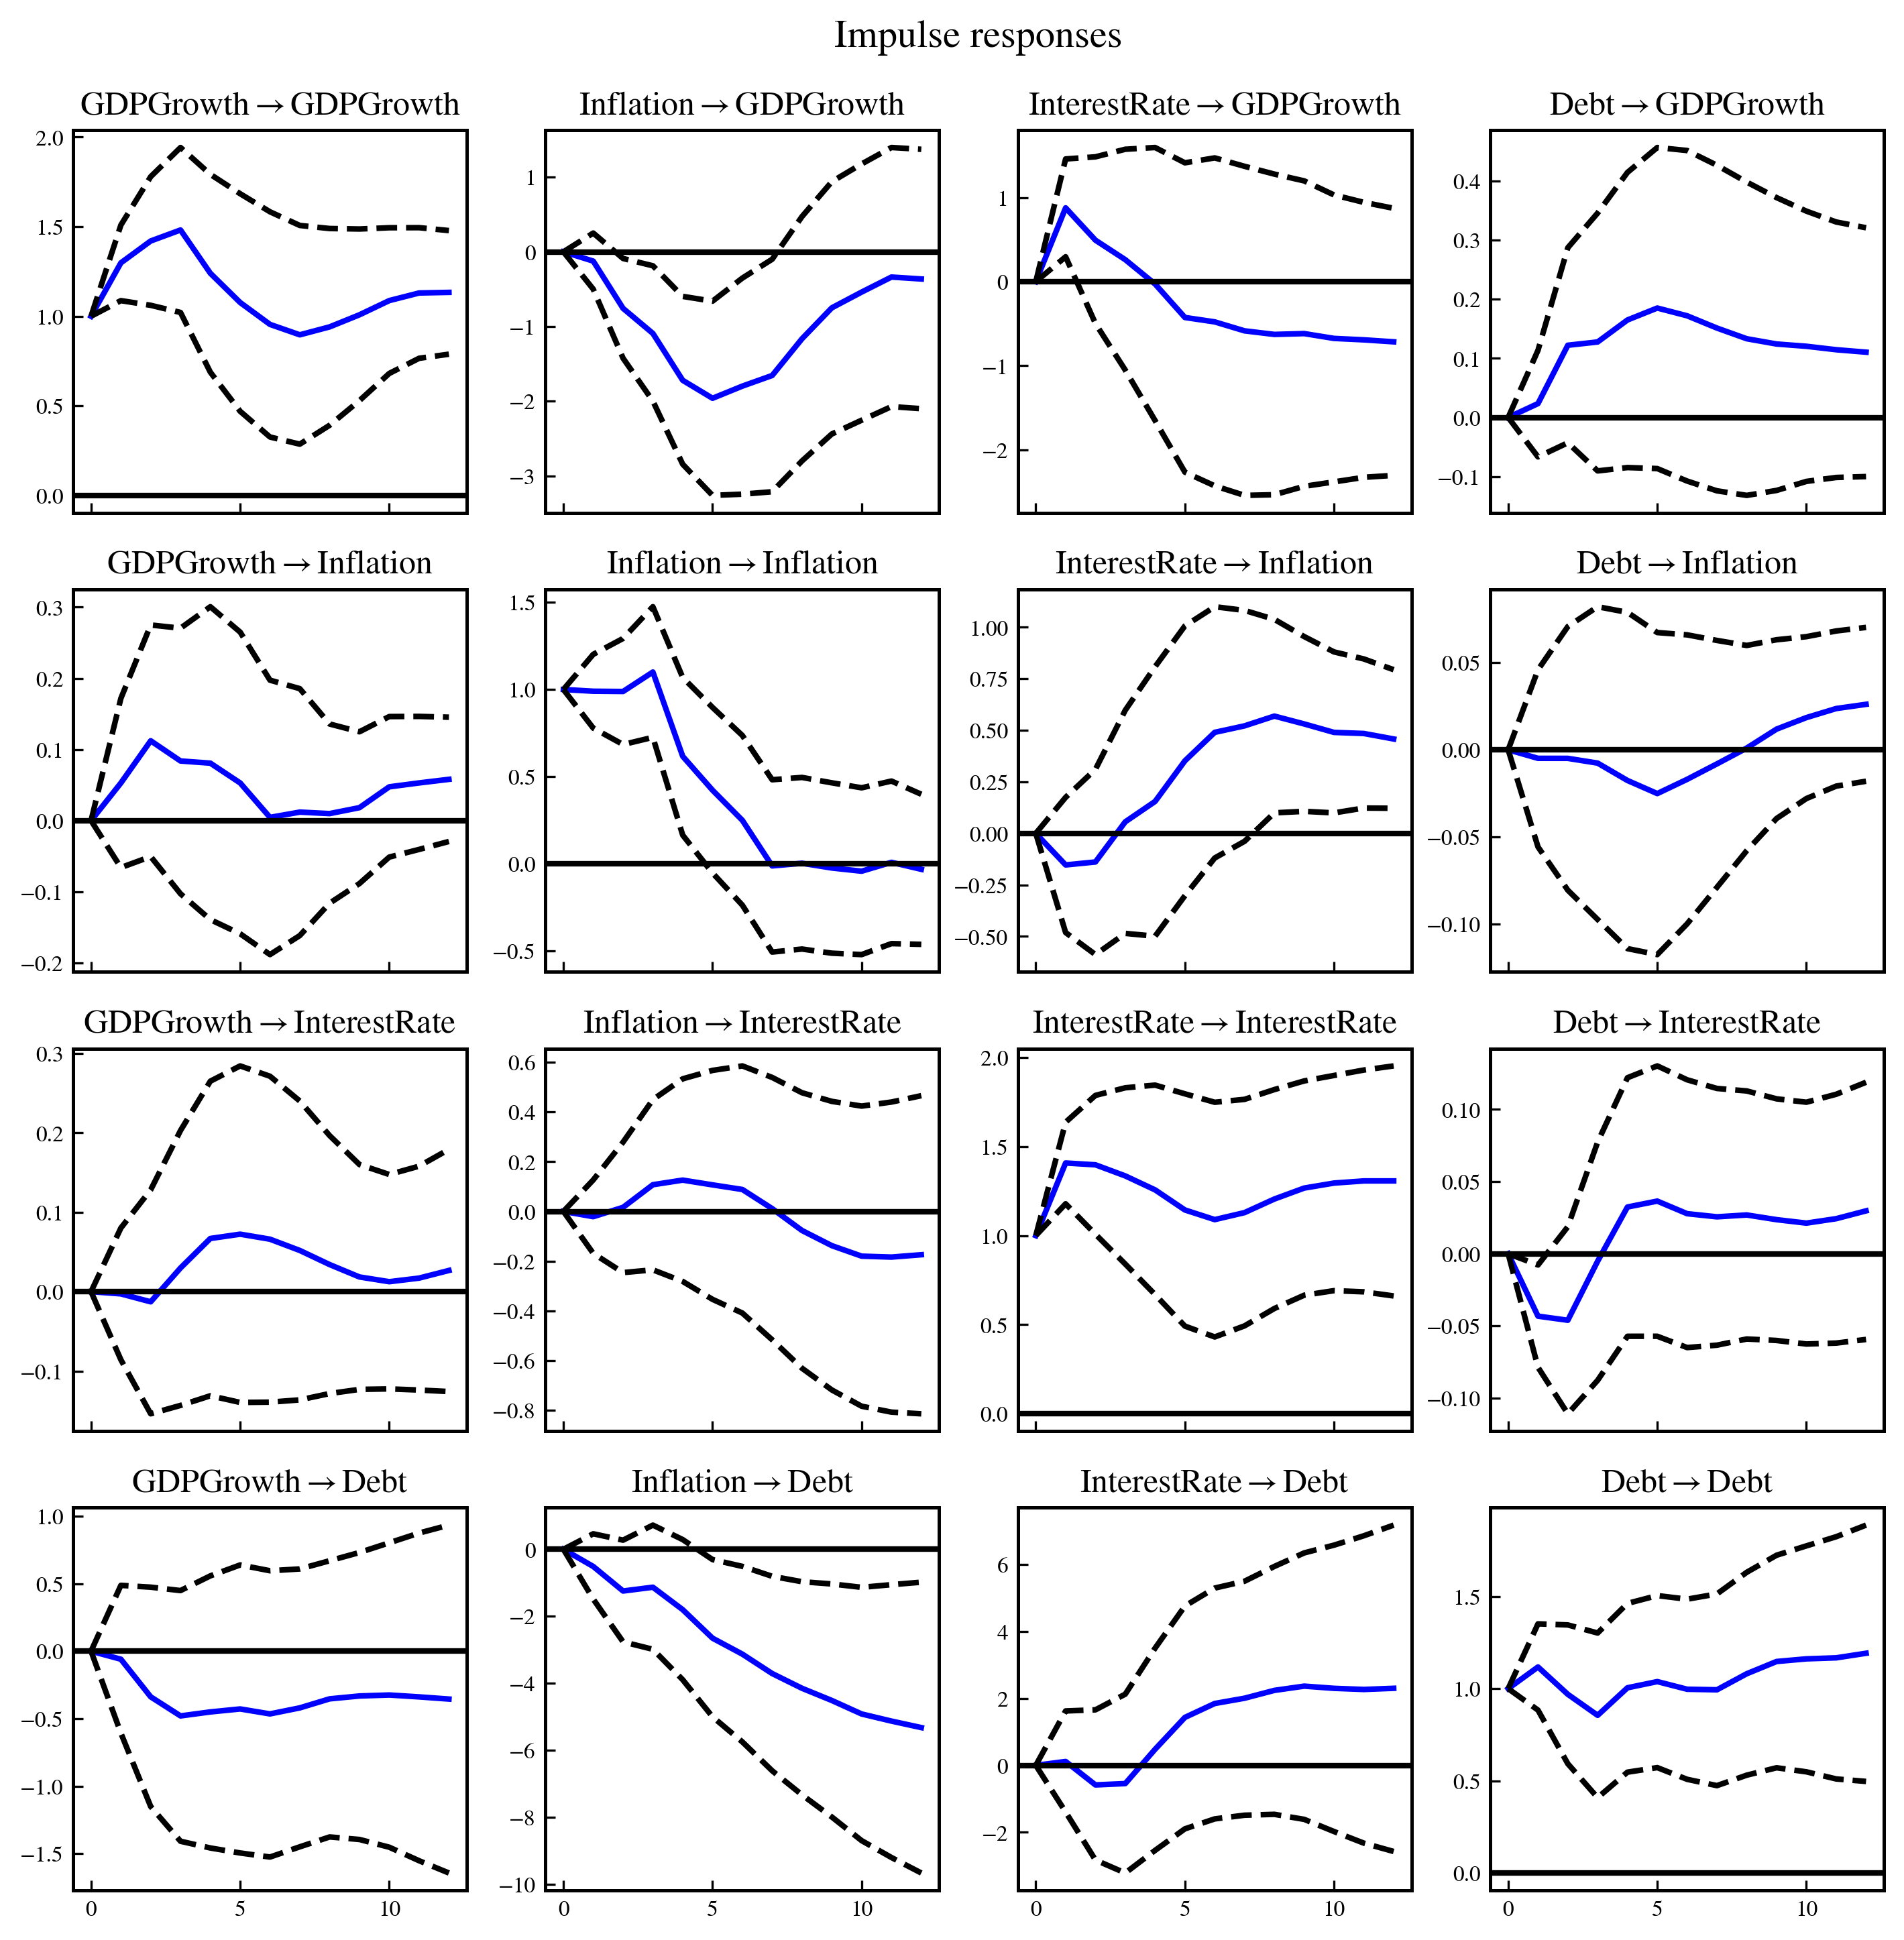

In [969]:
num_periods = 12
ir = vecm_res.irf(periods=num_periods)
fig=ir.plot(plot_stderr=True)
plt.savefig('VECM_IRF.pdf')